In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -*- coding: utf-8 -*-
"""MultiLetterObjectDetection.ipynb

Automatically generated by Colab.
"""

import os
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageDraw, ImageFont
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, Subset

# If you're using a notebook, uncomment for inline plots
# %matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [ ]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image

def create_pascal_voc_annotation(filename, image_shape, bboxes, labels, annotation_path):
    """
    Creates a Pascal VOC annotation XML file for the given bounding boxes.
    """
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'folder').text = os.path.basename(os.path.dirname(annotation_path))
    ET.SubElement(annotation, 'filename').text = filename

    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(image_shape[1])
    ET.SubElement(size, 'height').text = str(image_shape[0])
    ET.SubElement(size, 'depth').text = '3'  # Since we save RGB

    for bbox, label in zip(bboxes, labels):
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = str(label)
        ET.SubElement(obj, 'pose').text = 'Unspecified'
        ET.SubElement(obj, 'truncated').text = '0'
        ET.SubElement(obj, 'difficult').text = '0'
        bnd = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bnd, 'xmin').text = str(bbox[0])
        ET.SubElement(bnd, 'ymin').text = str(bbox[1])
        ET.SubElement(bnd, 'xmax').text = str(bbox[2])
        ET.SubElement(bnd, 'ymax').text = str(bbox[3])

    tree = ET.ElementTree(annotation)
    os.makedirs(os.path.dirname(annotation_path), exist_ok=True)
    tree.write(annotation_path)

def create_multi_letter_dataset(
    single_letter_data_dir,
    multi_letter_data_dir,
    classes_per_image=(2, 4),
    canvas_size=(512, 512)
):
    """
    Creates a dataset of images with multiple letters placed side-by-side,
    each letter centered along the y-axis (i.e., vertically).

    - single_letter_data_dir: root directory where each subfolder is a class containing single-letter images.
    - multi_letter_data_dir: output directory for multi-letter images + XML annotations.
    - classes_per_image: (min, max) number of letters to try placing on one canvas.
    - canvas_size: size of the blank canvas (width, height).
    """

    # Gather all image paths class-wise
    class_to_images = {}
    class_names = sorted(os.listdir(single_letter_data_dir))
    for class_name in class_names:
        class_path = os.path.join(single_letter_data_dir, class_name)
        if os.path.isdir(class_path):
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]
            if image_files:
                class_to_images[class_name] = [
                    os.path.join(class_path, f) for f in image_files
                ]

    os.makedirs(multi_letter_data_dir, exist_ok=True)

    num_composites = 2000
    for i in range(num_composites):
        # Attempt up to N letters per image
        n_letters = random.randint(classes_per_image[0], classes_per_image[1])

        # Create a blank white canvas
        canvas = Image.new('RGB', canvas_size, color=(255, 255, 255))

        bboxes = []
        labels = []

        current_x = 0

        for _ in range(n_letters):
            # Randomly pick a class and an image
            chosen_class = random.choice(list(class_to_images.keys()))
            img_path = random.choice(class_to_images[chosen_class])

            # Open and convert to RGB
            letter_img = Image.open(img_path).convert('RGB')

            # (Optional) Resize each letter to half its original size
            w, h = letter_img.size
            new_w, new_h = w // 2, h // 2
            letter_img = letter_img.resize((new_w, new_h), Image.LANCZOS)

            # Center this letter along the y-axis
            y = (canvas_size[1] - new_h) // 2

            # Check if it fits horizontally
            if current_x + new_w > canvas_size[0]:
                break  # no more letters can fit

            # Paste the letter
            canvas.paste(letter_img, (current_x, y))

            # Record bounding box
            xmin, ymin = current_x, y
            xmax, ymax = current_x + new_w, y + new_h
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(chosen_class)

            # Reduce spacing so letters are placed closer together
            spacing = 1
            current_x += new_w + spacing

        # Save the composite image
        out_filename = f"multi_{i:04d}.jpg"
        out_img_path = os.path.join(multi_letter_data_dir, out_filename)
        canvas.save(out_img_path, quality=95)

        # Create annotation
        annotation_filename = f"multi_{i:04d}.xml"
        annotation_path = os.path.join(multi_letter_data_dir, annotation_filename)
        create_pascal_voc_annotation(
            filename=out_filename,
            image_shape=(canvas_size[1], canvas_size[0]),
            bboxes=bboxes,
            labels=labels,
            annotation_path=annotation_path
        )

    print(f"Created {num_composites} multi-letter images in: {multi_letter_data_dir}")

In [ ]:
single_letter_data_dir = "/content/drive/MyDrive/learnpal/write/letters"    # Your single-letter dataset
multi_letter_data_dir  = "/content/drive/MyDrive/learnpal/write/multi_letters_v2"  # New multi-letter dataset
#create_multi_letter_dataset(single_letter_data_dir, multi_letter_data_dir)

In [ ]:
class MultiLetterDataset(Dataset):
    """
    A dataset where each .jpg/.png has a corresponding .xml (Pascal VOC),
    containing multiple letters (objects). We include a background class (label=0).
    """
    def __init__(self, root_dir, transforms=None):
        """
        root_dir: path to directory containing images + XMLs.
                  Each image "xxx.jpg" has an annotation "xxx.xml".
        transforms: optional torchvision transforms or custom transforms.
        """
        self.root_dir = root_dir
        self.transforms = transforms

        # Collect all valid image/annotation pairs
        self.img_paths = []
        self.annotation_paths = []

        # Identify images and match to XML
        for fname in os.listdir(root_dir):
            # Check if file is image-like
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                base_name, _ = os.path.splitext(fname)
                xml_path = os.path.join(root_dir, base_name + ".xml")
                if os.path.exists(xml_path):
                    self.img_paths.append(os.path.join(root_dir, fname))
                    self.annotation_paths.append(xml_path)

        # Build label map (with background=0)
        self.label_to_idx = {}  # e.g. {'A': 1, 'B': 2, ...}
        self.idx_to_label = {}
        self.num_classes = 0   # will be set in _build_label_mapping
        self._build_label_mapping()

    def _build_label_mapping(self):
        """
        Parse all annotations to gather unique labels,
        then map them to indices starting from 1 (since 0 is background).
        """
        unique_labels = set()
        for ann_path in self.annotation_paths:
            tree = ET.parse(ann_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text.strip()
                unique_labels.add(label)

        # Sort and assign each label an index starting from 1
        unique_labels = sorted(list(unique_labels))
        for i, label in enumerate(unique_labels, start=1):
            self.label_to_idx[label] = i

        # +1 for background (label 0)
        self.num_classes = len(unique_labels) + 1

        # Build reverse mapping if needed
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.annotation_paths[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse XML annotation
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label_name = obj.find('name').text.strip()
            # Convert label name to index (>= 1)
            label_idx = self.label_to_idx[label_name]

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_idx)

        # Convert to Torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)     # shape [N, 4]
        labels = torch.as_tensor(labels, dtype=torch.int64)     # shape [N]
        image_id = torch.tensor([idx])                          # just a single-element tensor

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id
        }

        if self.transforms is not None:
            # If you have transforms that operate on bounding boxes,
            # you may need a specialized approach. For simple transforms,
            # we can just do:
            img = self.transforms(img)

        return img, target

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def get_transform(train=True):
    # Simple transform: convert to tensor, optional color jitter, etc.
    transform_list = [T.ToTensor()]
    if train:
        transform_list.append(T.ColorJitter(brightness=0.5, hue=0.2))
    return T.Compose(transform_list)

def collate_fn(batch):
    return tuple(zip(*batch))

def get_object_detection_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Replace the classifier with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def train_multi_letter_dataset(multi_letter_data_dir, num_epochs=5):
    """
    Trains a Faster R-CNN model on the newly generated multi-letter dataset.
    """
    # Create dataset and split
    dataset = MultiLetterDataset(multi_letter_data_dir, transforms=get_transform(train=True))
    dataset_test = MultiLetterDataset(multi_letter_data_dir, transforms=get_transform(train=False))

    print("Total images:", len(dataset))
    print("Number of classes (with background):", dataset.num_classes)

    # Train/test split
    indices = torch.randperm(len(dataset)).tolist()
    split = int(0.8 * len(dataset))
    train_indices, test_indices = indices[:split], indices[split:]
    dataset_train = Subset(dataset, train_indices)
    dataset_test = Subset(dataset_test, test_indices)

    # DataLoaders
    train_loader = DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn
    )
    test_loader = DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
    )

    # Model
    num_classes = dataset.num_classes  # includes background
    model = get_object_detection_model(num_classes)
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for i, (images, targets) in enumerate(train_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        scheduler.step(losses)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    print("Training complete.")

    # Save model
    model_path = os.path.join(multi_letter_data_dir, "multi_letter_detector2.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    return model, model_path, test_loader


In [ ]:
model, model_path, test_loader = train_multi_letter_dataset(multi_letter_data_dir, num_epochs=30)

Total images: 2000
Number of classes (with background): 275


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 199MB/s]


Epoch [1/30], Loss: 1.0643
Epoch [2/30], Loss: 0.9788
Epoch [3/30], Loss: 0.8255
Epoch [4/30], Loss: 0.6688
Epoch [5/30], Loss: 0.5212
Epoch [6/30], Loss: 0.4155
Epoch [7/30], Loss: 0.3354
Epoch [8/30], Loss: 0.2797
Epoch [9/30], Loss: 0.2460
Epoch [10/30], Loss: 0.2142
Epoch [11/30], Loss: 0.1942
Epoch [12/30], Loss: 0.1748
Epoch [13/30], Loss: 0.1607
Epoch [14/30], Loss: 0.1477
Epoch [15/30], Loss: 0.1406
Epoch [16/30], Loss: 0.1291
Epoch [17/30], Loss: 0.1219
Epoch [18/30], Loss: 0.1155
Epoch [19/30], Loss: 0.1106
Epoch [20/30], Loss: 0.1056
Epoch [21/30], Loss: 0.1010
Epoch [22/30], Loss: 0.0979
Epoch [23/30], Loss: 0.0927
Epoch [24/30], Loss: 0.0888
Epoch [25/30], Loss: 0.0869
Epoch [26/30], Loss: 0.0823
Epoch [27/30], Loss: 0.0799
Epoch [28/30], Loss: 0.0782
Epoch [29/30], Loss: 0.0753
Epoch [30/30], Loss: 0.0735
Training complete.
Model saved at /content/drive/MyDrive/learnpal/write/multi_letters_v2/multi_letter_detector2.pth


In [ ]:
import pickle
df = pd.read_excel('/content/drive/MyDrive/learnpal/write/letters (added).xlsx')
class_mapping = pd.Series(df['letters'].values, index=df['idx']).to_dict()
with open("class_mapping2.pkl", "wb") as f:
    pickle.dump(class_mapping, f)

<ipython-input-11-64caab60920f>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


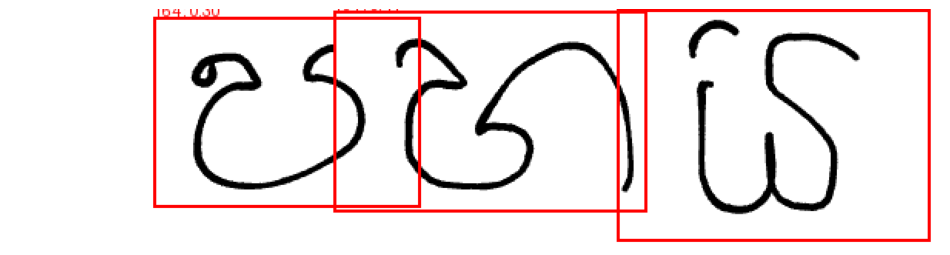

Final predicted letters in order:  ['164', '101', '274']

Predicted sequence: පහාම්


In [ ]:
import os
import pickle
import torch
import torchvision
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import to_pil_image
import pandas as pd

# ------------------------------------------------
# 1) Define function to initialize the same model
#    architecture used during training
# ------------------------------------------------
def get_object_detection_model(num_classes):
    """
    Loads a FasterRCNN_ResNet50_FPN_V2 model and replaces the final predictor
    with one compatible with your custom num_classes.
    """
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)

    # Replace the pretrained head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# ------------------------------------------------
# 2) Inference function
# ------------------------------------------------
def infer(
    model_path,
    image_path,
    class_mapping_path="class_mapping.pkl",
    threshold=0.5,
    proximity_threshold=5
):
    """
    Loads a trained Faster R-CNN model, performs inference on a single image,
    applies a confidence threshold, and then handles overlapping bounding boxes.

    Args:
        model_path (str): Path to the trained .pth model file.
        image_path (str): Path to the input image.
        class_mapping_path (str): Path to the pickled dictionary of
                                  {class_idx: class_name} from training.
        threshold (float): Confidence threshold for filtering predictions.
        proximity_threshold (int): Overlapping bounding box threshold (pixels).
    Returns:
        final_predictions_in_order (list): A list of predicted class names in
                                           left-to-right order.
    """

    # --------------------------
    # Step A: Load model
    # --------------------------
    # First, load the saved class mapping if available
    # This mapping is typically {1: "A", 2: "B", ...} for your custom classes
    if os.path.exists(class_mapping_path):
        with open(class_mapping_path, "rb") as f:
            class_mapping = pickle.load(f)
    else:
        # Fallback if you don't have a pickle file
        # or prefer to handle it differently
        class_mapping = {}
        print("WARNING: No class_mapping.pkl found. Labels will be shown as numeric IDs.")

    # Determine how many classes (including background)
    # If you included background in idx_to_label, your max index might be "num_classes - 1".
    # Example: if the dataset had 26 letters + 1 background = 27 classes, the mapping
    # might go up to idx 26.
    # So let's guess from the mapping:
    if len(class_mapping) > 0:
        num_classes = max(class_mapping.keys()) + 1  # +1 if background=0 isn't in the mapping
    else:
        # Hardcode if needed
        num_classes = 27  # Example only

    # Create the model structure and load weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = get_object_detection_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)

    # --------------------------
    # Step B: Preprocess image
    # --------------------------
    image = Image.open(image_path).convert("RGB")
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    transform = weights.transforms()
    img_tensor = transform(image).unsqueeze(0).to(device)

    # --------------------------
    # Step C: Run inference
    # --------------------------
    with torch.no_grad():
        predictions = model(img_tensor)

    # The predictions will be a list (for each input image) of dicts:
    # predictions[0]["boxes"] -> bounding boxes
    # predictions[0]["labels"] -> predicted class indices
    # predictions[0]["scores"] -> scores for each prediction
    boxes = predictions[0]["boxes"].cpu().numpy()
    labels = predictions[0]["labels"].cpu().numpy()
    scores = predictions[0]["scores"].cpu().numpy()

    # --------------------------
    # Step D: Filter by threshold
    # --------------------------
    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []
    for i, score in enumerate(scores):
        if score > threshold:
            filtered_boxes.append(boxes[i])
            filtered_labels.append(labels[i])
            filtered_scores.append(score)

    # --------------------------
    # Step E: Handle overlaps by comparing x1/x2
    # --------------------------
    final_boxes = []
    final_labels = []
    final_scores = []
    visited = [False] * len(filtered_boxes)

    for i in range(len(filtered_boxes)):
        if visited[i]:
            continue
        current_box = filtered_boxes[i]
        x1_current, _, x2_current, _ = current_box

        # Group all boxes that are "close" in x1,x2 coordinates
        overlapping_indices = []
        for j in range(len(filtered_boxes)):
            if not visited[j]:
                x1_other, _, x2_other, _ = filtered_boxes[j]
                if (abs(x1_current - x1_other) <= proximity_threshold or
                        abs(x2_current - x2_other) <= proximity_threshold):
                    overlapping_indices.append(j)

        # Among all overlapping boxes, pick the one with the highest confidence
        best_index = max(overlapping_indices, key=lambda idx: filtered_scores[idx])
        final_boxes.append(filtered_boxes[best_index])
        final_labels.append(filtered_labels[best_index])
        final_scores.append(filtered_scores[best_index])

        # Mark them visited
        for idx in overlapping_indices:
            visited[idx] = True

    # --------------------------
    # Step F: Sort results left->right
    # --------------------------
    # Sort final boxes by x1 coordinate
    sorted_indices = sorted(range(len(final_boxes)), key=lambda i: final_boxes[i][0])

    # --------------------------
    # Step G: Draw and display
    # --------------------------
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    font = ImageFont.load_default()

    final_predictions_in_order = []
    for idx in sorted_indices:
        box = final_boxes[idx]
        label = final_labels[idx]
        score = final_scores[idx]
        x1, y1, x2, y2 = box.astype(int)

        # If you have a mapping from label -> string
        class_name = class_mapping[label] if label in class_mapping else f"Label_{label}"

        # Draw bounding box
        draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=2)
        text = f"{class_name} : {score:.2f}"
        draw.text((x1, y1 - 10), text, fill="red", font=font)

        final_predictions_in_order.append(class_name)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_draw)
    plt.axis("off")
    plt.show()

    print("Final predicted letters in order: ", final_predictions_in_order)
    return final_predictions_in_order


# ------------------------------------------------
# 3) Example usage (if run as script)
# ------------------------------------------------
if __name__ == "__main__":
    # Example paths
    model_path = multi_letter_data_dir+"/multi_letter_detector2.pth"   # or "letters_detection.pth" in your snippet
    image_path = "49.png"     # path to an image
    class_mapping_path = "class_mapping.pkl"
    class_mapping_path2 = "class_mapping2.pkl"    # ensure this file exists if you want label->string

    results = infer(
        model_path=model_path,
        image_path=image_path,
        class_mapping_path=class_mapping_path,
        threshold=0.1,        # or 0.5
        proximity_threshold=5
    )

    if  os.path.exists(class_mapping_path2):
        with open(class_mapping_path2, "rb") as f:
            class_mapping2 = pickle.load(f)
    results = [class_mapping2[int(i)] for i in results]

    print("\nPredicted sequence:", "".join(results))
